https://github.com/brian-team/brian2modelfitting/issues/46

In [1]:
import os

import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

In [2]:
def simulator(parameter_set):
    return parameter_set + torch.randn(parameter_set.shape) * 0.1

In [3]:
# data
prior = utils.BoxUniform(low=-2*torch.ones(3), high=2*torch.ones(3))
observation = torch.zeros(3)
x_o = simulator(observation)

# learning the density estimator and building the posterior
simulator, prior = prepare_for_sbi(simulator, prior)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=100, num_workers=4)

# creating a posterior from neural density estimator
inference = SNPE(prior)
density_estimator = inference.append_simulations(theta, x).train()
og_posterior = inference.build_posterior(density_estimator)

# sampling from the posterior
#samples = og_posterior.sample((10000,), x=observation)
#log_probability = og_posterior.log_prob(samples, x=observation)
#_ = analysis.pairplot(samples,
#                      figsize=(6, 6),
#                      points=x_o,
#                      points_offdiag={'markersize': 6},
#                      points_colors=['r'])

# save the density estimator state dictionary
torch.save(og_posterior.net, os.path.join('output', 'psd.pth'))

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

Neural network successfully converged after 197 epochs.


In [5]:
new_inference = SNPE(prior)
density_estimator_loaded = torch.load(os.path.join('output', 'psd.pth'))
new_posterior = new_inference.build_posterior(density_estimator_loaded)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

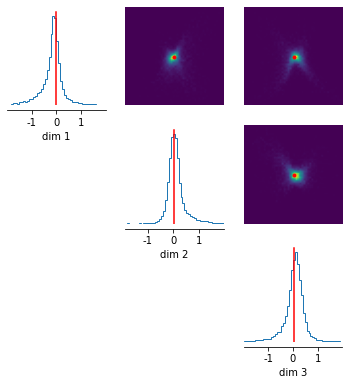

In [6]:
# sampling from the new posterior
samples = new_posterior.sample((10000,), x=observation)
log_probability = new_posterior.log_prob(samples, x=observation)
_ = analysis.pairplot(samples,
                      figsize=(6, 6),
                      points=x_o,
                      points_offdiag={'markersize': 6},
                      points_colors=['r'])